# 0. Parallel Ensembles

This notebook is aimed at showing how to use the parallel and mini-batch variants of the ensembles.

* Examples of all the parallel ensembles available.
* Examples on how to use the parallel versions.
* Example of the trade-off between runtime and accuracy when using the parallel ensembles.

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 30/05/2024**

## 1. Using the most basic bagging ensemble

* **CapyMOA chooses between the standard and the mini-batch version behind the curtains based on the parameter configuration used**

* For more information about the parallel ensembles please refer to the following references: 

`Guilherme Cassales, Heitor Gomes, Albert Bifet, Bernhard Pfahringer, Hermes Senger, Improving the performance of bagging ensembles for data streams through mini-batching, Information Sciences,Volume 580, 2021, Pages 260-282, ISSN 0020-0255, https://doi.org/10.1016/j.ins.2021.08.085.`

`G. Cassales, H. M. Gomes, A. Bifet, B. Pfahringer and H. Senger, "Balancing Performance and Energy Consumption of Bagging Ensembles for the Classification of Data Streams in Edge Computing," in IEEE Transactions on Network and Service Management, vol. 20, no. 3, pp. 3038-3054, Sept. 2023, doi: 10.1109/TNSM.2022.3226505.`

In [11]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import RBFm_100k
from capymoa.classifier import OnlineBagging
from capymoa.evaluation.visualization import plot_windowed_results

rbf_100k = RBFm_100k()

ozabag_sequential = OnlineBagging(schema=rbf_100k.schema, ensemble_size=10)
ozabag_mb_parallel = OnlineBagging(schema=rbf_100k.schema, ensemble_size=10, minibatch_size=25, number_of_jobs=5)


### 1.1 Understanding the parameters

- Since we used different parameters in the constructor call, each instace references a different object
	- sequential: note the CLI help only mention `baseLearner` and `ensembleSize`
	- parallel: note the extra parameters `numCores` and `batchSize`
- Setting the parallel parameters on the constructor call will make it a minibatch parallel ensemble.

In [2]:
print(ozabag_sequential.CLI_help())

-l baseLearner (default: trees.HoeffdingTree)
Classifier to train.
-s ensembleSize (default: 10)
The number of models in the bag.



In [3]:
print(ozabag_mb_parallel.CLI_help())

-l baseLearner (default: trees.HoeffdingTree)
Classifier to train.
-s ensembleSize (default: 10)
The number of models in the bag.
-c numCores (default: 1)
The amount of CPU Cores used for multi-threading
-b batchSize (default: 1)
The amount of instances the classifier should buffer before training.



### 1.2 Example comparing sequential and parallel

In [12]:
result_seq = prequential_evaluation(stream=rbf_100k, learner=ozabag_sequential)
result_par = prequential_evaluation(stream=rbf_100k, learner=ozabag_mb_parallel)

- Note that the minibatch approach creates a divergence in the results for two reasons:
	1) it uses local random generators instead of a global one;
	2) the mini-batch defers the model update by a few instances which causes differences in the predictions;
- On the bright side, it decreases runtime

Cumulative accuracy = 61.939
wallclock = 8.663465023040771 seconds

Cumulative accuracy = 61.47
wallclock = 6.425909042358398 seconds


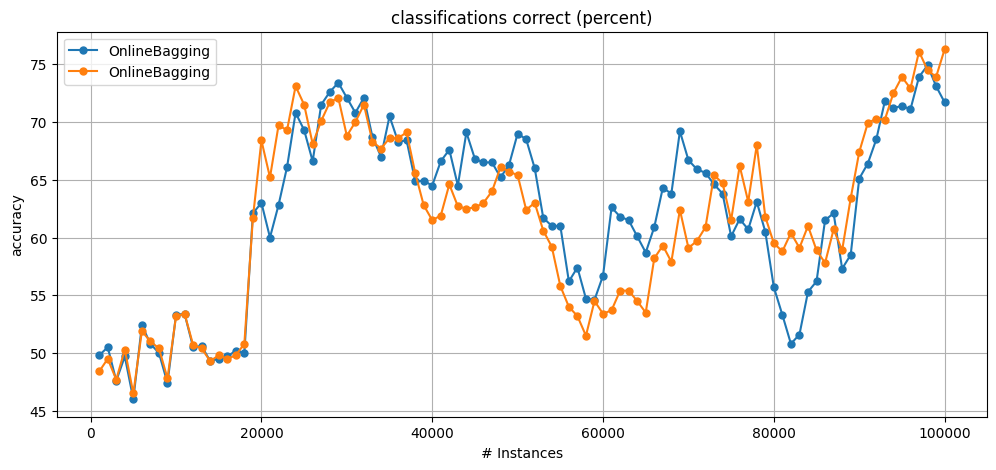

In [5]:
# decoupling the running and plotting to allow more flexibility
print(f"Cumulative accuracy = {result_seq['cumulative'].accuracy()}")
print(f"wallclock = {result_seq['wallclock']} seconds")
print("")
print(f"Cumulative accuracy = {result_par['cumulative'].accuracy()}")
print(f"wallclock = {result_par['wallclock']} seconds")
plot_windowed_results(result_seq, result_par, ylabel="accuracy")

### 1.3 Increasing the ensemble size
- Ensembles with more learners will get a bigger decrease in processing time.
- Let's see the difference when using 100 classifiers

In [6]:
ozabag_sequential = OnlineBagging(schema=rbf_100k.schema, ensemble_size=100)
ozabag_mb_parallel = OnlineBagging(schema=rbf_100k.schema, ensemble_size=100, minibatch_size=25, number_of_jobs=5)
result_seq100 = prequential_evaluation(stream=rbf_100k, learner=ozabag_sequential)
result_par100 = prequential_evaluation(stream=rbf_100k, learner=ozabag_mb_parallel)

Cumulative accuracy = 63.617000000000004
wallclock = 88.99457597732544 seconds

Cumulative accuracy = 62.778999999999996
wallclock = 58.45238900184631 seconds


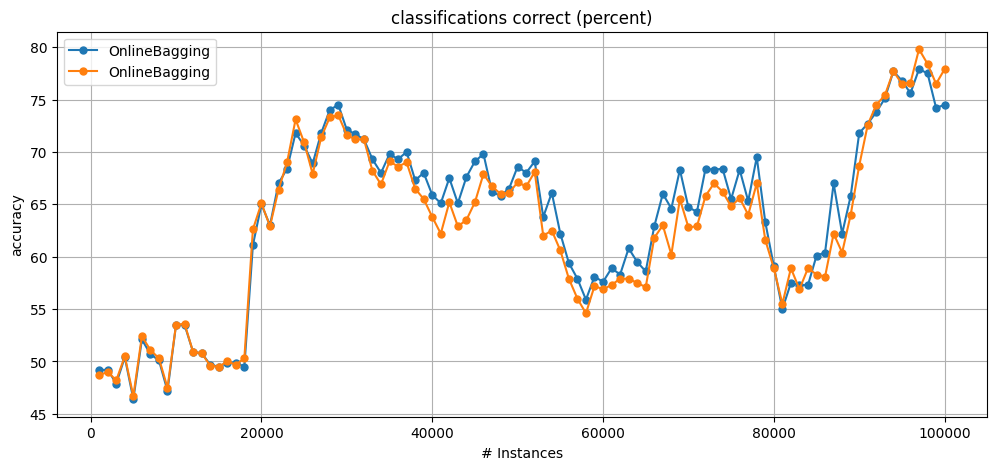

In [7]:
# decoupling the running and plotting to allow more flexibility
print(f"Cumulative accuracy = {result_seq100['cumulative'].accuracy()}")
print(f"wallclock = {result_seq100['wallclock']} seconds")
print("")
print(f"Cumulative accuracy = {result_par100['cumulative'].accuracy()}")
print(f"wallclock = {result_par100['wallclock']} seconds")
plot_windowed_results(result_seq100, result_par100, ylabel="accuracy")

## 2. Other variations

- Sequential execution with the minibatch
- Parallel execution of the incremental approach

In [8]:
mbSeq = OnlineBagging(schema=rbf_100k.get_schema(), ensemble_size=10, minibatch_size=25)
incPar = OnlineBagging(schema=rbf_100k.get_schema(), ensemble_size=10, minibatch_size=1, number_of_jobs=5)
result_mbSeq = prequential_evaluation(stream=rbf_100k, learner=mbSeq)
result_incPar = prequential_evaluation(stream=rbf_100k, learner=incPar)

- Incremental Sequential differs from Incremental Parallel because of the random sequences;
- When compared among themselves, mini-batch parallel and mini-batch sequential (single-core) have the same accuracy, as their random sequences are initialized in the same way;
- Incremental Parallel has the same random sequences as the Mini-batch versions, its improvement comes from making all the predictions with the most up-to-date model;


Incremental Sequential 
Cumulative accuracy = 61.939
wallclock = 8.597954988479614 seconds

Mini-batch Parallel
Cumulative accuracy = 61.47
wallclock = 6.4126739501953125 seconds

Mini-atch Sequential
Cumulative accuracy = 61.47
wallclock = 8.872874021530151 seconds

Incremental Parallel 
Cumulative accuracy = 61.498
wallclock = 10.221993923187256 seconds



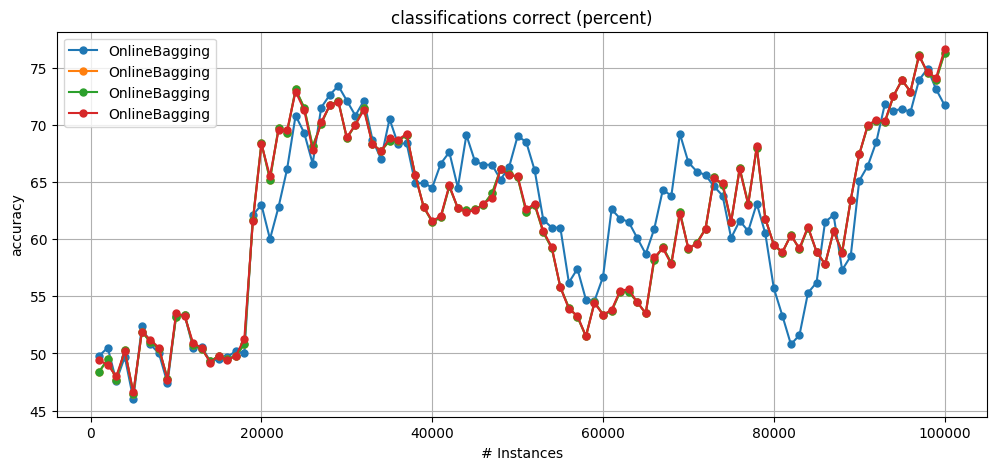

In [14]:
# decoupling the running and plotting to allow more flexibility
print("Incremental Sequential ")
print(f"Cumulative accuracy = {result_seq['cumulative'].accuracy()}")
print(f"wallclock = {result_seq['wallclock']} seconds\n")
print("Mini-batch Parallel")
print(f"Cumulative accuracy = {result_par['cumulative'].accuracy()}")
print(f"wallclock = {result_par['wallclock']} seconds\n")
print("Mini-atch Sequential")
print(f"Cumulative accuracy = {result_mbSeq['cumulative'].accuracy()}")
print(f"wallclock = {result_mbSeq['wallclock']} seconds\n")
print("Incremental Parallel ")
print(f"Cumulative accuracy = {result_incPar['cumulative'].accuracy()}")
print(f"wallclock = {result_incPar['wallclock']} seconds\n")
plot_windowed_results(result_seq, result_par, result_mbSeq, result_incPar, ylabel="accuracy")

## 3. More ensembles

There are more mini-batch ensembles with parallelism implemented

- AdaptiveRandomForest
- LeveragingBagging
- OzaBagAdwin

In [3]:
from capymoa.stream import Stream
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from moa.streams.filters import StandardisationFilter, NormalisationFilter
from moa.streams import FilteredStream

rbf_100k = RBFm_100k()

# print(f'MOA creation string for data: {rbf_100k.moa_stream.getCLICreationString(rbf_100k.moa_stream.__class__)}')

# Create a FilterStream and use the NormalisationFilter
rbf_stream_normalised = Stream(CLI=f"-s ({rbf_100k.moa_stream.getCLICreationString(rbf_100k.moa_stream.__class__)}) \
-f NormalisationFilter ", moa_stream=FilteredStream())

# print(f'MOA creation string for filtered version: {rbf_stream_normalised.moa_stream.getCLICreationString(rbf_stream_normalised.moa_stream.__class__)}')

ob_learner_norm = OnlineBagging(schema=rbf_stream_normalised.get_schema(), ensemble_size=5)
ob_learner = OnlineBagging(schema=rbf_100k.get_schema(), ensemble_size=5)

ob_results_norm = prequential_evaluation(stream=rbf_stream_normalised, learner=ob_learner_norm)
ob_results = prequential_evaluation(stream=rbf_100k, learner=ob_learner)


print(f"Accuracy with online normalization: {ob_results_norm['cumulative'].accuracy()}")
print(f"Accuracy without normalization: {ob_results['cumulative'].accuracy()}")

Accuracy with online normalization: 61.815
Accuracy without normalization: 60.357000000000006


## 3. Comparing a MOA and SKLearn models

* This simple example shows how it is simple to compare a MOA and a SKLearn regressors. 
* For the sake of this example, we are using the wrappers
* SKClassifier (and SKRegressor) are parametrized directly as part of the object initialization
* MOAClassifier (and MOARegressor) are parametrized through a CLI (a separate parameter)

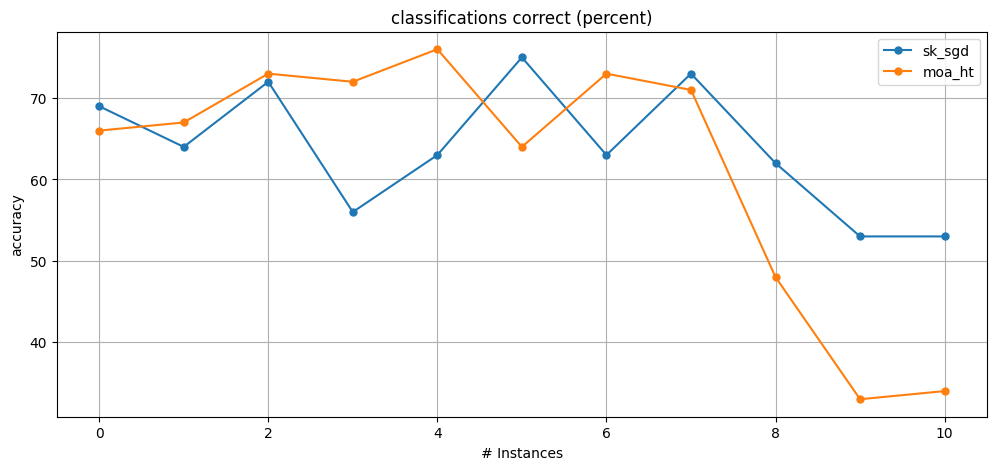

In [4]:
from capymoa.base import SKClassifier, MOAClassifier
from capymoa.datasets import CovtypeTiny
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results

from sklearn.linear_model import SGDClassifier
from moa.classifiers.trees import HoeffdingTree

covt_tiny = CovtypeTiny()

sk_sgd = SKClassifier(schema=covt_tiny.schema, sklearner=SGDClassifier(loss='log_loss', penalty='l1', alpha=0.001))
moa_ht = MOAClassifier(schema=covt_tiny.schema, moa_learner=HoeffdingTree, CLI="-g 50")

results = prequential_evaluation_multiple_learners(stream=covt_tiny, learners={'sk_sgd':sk_sgd, 'moa_ht':moa_ht}, window_size=100)
plot_windowed_results(results['sk_sgd'], results['moa_ht'], ylabel="accuracy")

## 4. Creating Python learners with MOA Objects

* This example follow the example from `06_new_learner` which shows how to create a custom online bagging implementation.
* Here we also create an online bagging implementation, but the base_learner is a MOA class

In [5]:
from capymoa.base import Classifier, MOAClassifier
from moa.classifiers.trees import HoeffdingTree
from collections import Counter
import numpy as np
import random
import math

def poisson(lambd, random_generator):
    if lambd < 100.0:
        product = 1.0
        _sum = 1.0
        threshold = random_generator.random() * math.exp(lambd)
        i = 1
        max_val = max(100, 10 * math.ceil(lambd))
        while i < max_val and _sum <= threshold:
            product *= (lambd / i)
            _sum += product
            i += 1
        return i - 1
    x = lambd + math.sqrt(lambd) * random_generator.gauss(0, 1)
    if x < 0.0:
        return 0
    return int(math.floor(x))

class CustomOnlineBagging(Classifier):
    def __init__(self, schema=None, random_seed=1, ensemble_size=5, moa_base_learner_class=None, CLI_base_learner=None):
        super().__init__(schema=schema, random_seed=random_seed)

        self.random_generator = random.Random()
        self.CLI_base_learner = CLI_base_learner
        
        self.ensemble_size = ensemble_size
        self.moa_base_learner_class = moa_base_learner_class
        
        # Default base learner if None is specified
        if self.moa_base_learner_class is None:
            self.moa_base_learner_class = HoeffdingTree
        
        self.ensemble = []
        # Create several instances for the base_learners
        for i in range(self.ensemble_size): 
            self.ensemble.append(MOAClassifier(schema=self.schema, moa_learner=self.moa_base_learner_class(), CLI=self.CLI_base_learner))
        
    def __str__(self):
        return 'CustomOnlineBagging'

    def train(self, instance):
        for i in range(self.ensemble_size):
            k = poisson(1.0, self.random_generator)
            for _ in range(k):
                self.ensemble[i].train(instance)

    def predict(self, instance):
        predictions = []
        for i in range(self.ensemble_size):
            predictions.append(self.ensemble[i].predict(instance))
        majority_vote = Counter(predictions)
        prediction = majority_vote.most_common(1)[0][0]
        return prediction

    def predict_proba(self, instance):
        probabilities = []
        for i in range(self.ensemble_size):
            classifier_proba = self.ensemble[i].predict_proba(instance)
            classifier_proba = classifier_proba / np.sum(classifier_proba)
            probabilities.append(classifier_proba)
        avg_proba = np.mean(probabilities, axis=0)
        return avg_proba



### 4.1 Testing the custom online bagging

* We choose to use an HoeffdingAdaptiveTree from MOA as the base learner
* We also specify the CLI commands to configure the base learner

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.stream import stream_from_file
from moa.classifiers.trees import HoeffdingAdaptiveTree

elec_stream = stream_from_file(path_to_csv_or_arff="../data/electricity.csv")

# Creating a learner: using a hoeffding adaptive tree as the base learner with grace period of 50 (-g 50)
NEW_OB = CustomOnlineBagging(schema=elec_stream.get_schema(), 
                             ensemble_size=5, 
                             moa_base_learner_class=HoeffdingAdaptiveTree, 
                             CLI_base_learner="-g 50")

results_NEW_OB = prequential_evaluation(stream=elec_stream, learner=NEW_OB, window_size=4500)

results_NEW_OB['cumulative'].accuracy()

83.30685028248588

## 5. Using TensorBoard with PyTorch in CapyMOA

* One can use TensorBoard to visualize logged data in an online fashion
* We go through all the steps below, including installing TensorBoard

### 5.1 Install TensorBoard
Clear any logs from previous runs

```sh
rm -rf ./runs
```

In [7]:
!pip install tensorboard

### 5.2  PyTorchClassifier
* We define `PyTorchClassifier` and `NeuralNetwork` classes similarly to those from **Tutorial 3**: `Using Pytorch with CapyMOA`

In [8]:
from capymoa.base import Classifier
import numpy as np
import torch
from torch import nn

torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

# Get cpu device for training.
device = ("cpu")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=0, number_of_classes=0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, number_of_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class PyTorchClassifier(Classifier):
    def __init__(self, schema=None, random_seed=1, nn_model: nn.Module = None, optimizer=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3):
        super().__init__(schema, random_seed)
        self.model = None
        self.optimizer = None
        self.loss_fn = loss_fn
        self.lr = lr
        self.device = device
        
        torch.manual_seed(random_seed)
        
        if nn_model is None:
            self.set_model(None)
        else:
            self.model = nn_model.to(device)
        if optimizer is None:
            if self.model is not None:
                self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        else:
            self.optimizer = optimizer
        
    def __str__(self):
        return str(self.model)

    def CLI_help(self):
        return str('schema=None, random_seed=1, nn_model: nn.Module = None, optimizer=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3')

    def set_model(self, instance):
        if self.schema is None:
            moa_instance = instance.java_instance.getData()
            self.model = NeuralNetwork(input_size=moa_instance.get_num_attributes(), number_of_classes=moa_instance.get_num_classes()).to(self.device)
        elif instance is not None:
            self.model = NeuralNetwork(input_size=self.schema.get_num_attributes(), number_of_classes=self.schema.get_num_classes()).to(self.device)
            
    def train(self, instance):
        if self.model is None:
            self.set_model(instance)
    
        X = torch.tensor(instance.x, dtype=torch.float32)
        y = torch.tensor(instance.y_index, dtype=torch.long)
        # set the device and add a dimension to the tensor
        X, y = torch.unsqueeze(X.to(self.device), 0), torch.unsqueeze(y.to(self.device),0)

        # Compute prediction error
        pred = self.model(X)
        loss = self.loss_fn(pred, y)
    
        # Backpropagation
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def predict(self, instance):
        return np.argmax(self.predict_proba(instance))

    def predict_proba(self, instance):
        if self.model is None:
            self.set_model(instance)
        X = torch.unsqueeze(torch.tensor(instance.x, dtype=torch.float32).to(self.device), 0)
        # turn off gradient collection
        with torch.no_grad():
            pred = np.asarray(self.model(X).numpy(), dtype=np.double)
        return pred


### 5.3  PyTorchClassifier + the test-then-train loop + TensorBoard
* Here we use instance loop to log relevant log information to TensorBoard
* These information can be viewed while the processing is happening using TensorBoard

In [9]:
from capymoa.evaluation import ClassificationEvaluator
from capymoa.datasets import RBFm_100k
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter instance.
writer = SummaryWriter()
## Opening a file again to start from the beginning
rbf_stream = RBFm_100k()

# Creating the evaluator
evaluator = ClassificationEvaluator(schema=rbf_stream.get_schema())

# Creating a learner
simple_pyTorch_classifier = PyTorchClassifier(
    schema=rbf_stream.get_schema(), 
    nn_model=NeuralNetwork(input_size=rbf_stream.get_schema().get_num_attributes(), 
                           number_of_classes=rbf_stream.get_schema().get_num_classes()).to(device)
)

i = 0
while rbf_stream.has_more_instances():
    i += 1
    instance = rbf_stream.next_instance()

    prediction = simple_pyTorch_classifier.predict(instance)
    evaluator.update(instance.y_index, prediction)
    simple_pyTorch_classifier.train(instance)
    
    if i % 1000 == 0:
        writer.add_scalar("accuracy", evaluator.accuracy(), i)

    if i % 10000 == 0:
        print(f"Processed {i} instances")

writer.add_scalar("accuracy", evaluator.accuracy(), i)
# Call flush() method to make sure that all pending events have been written to disk.
writer.flush()

# If you do not need the summary writer anymore, call close() method.
writer.close()

Processed 10000 instances
Processed 20000 instances
Processed 30000 instances
Processed 40000 instances
Processed 50000 instances
Processed 60000 instances
Processed 70000 instances
Processed 80000 instances
Processed 90000 instances
Processed 100000 instances


#### 5.4 Run TensorBoard
Now, start TensorBoard, specifying the root log directory you used above. 
Argument ``logdir`` points to directory where TensorBoard will look to find 
event files that it can display. TensorBoard will recursively walk 
the directory structure rooted at ``logdir``, looking for ``.*tfevents.*`` files.

```sh
tensorboard --logdir=runs
```
Go to the URL it provides

This dashboard shows how the accuracy change with time. 
You can use it to also track training speed, learning rate, and other 
scalar values.

## 6. Creating a synthetic stream with concept drifts from MOA

* Demonstrates the flexibility of the API, these level of manipulation of the API is expected from experienced MOA users.
* To use the API like this the user must be familiar with how concept drifts are simulatd in MOA

EvaluatePrequential -l trees.HoeffdingAdaptiveTree **-s (ConceptDriftStream -s generators.AgrawalGenerator -d (generators.AgrawalGenerator -f 2) -p 5000)** -e (WindowClassificationPerformanceEvaluator **-w 100**) **-i 10000 -f 100**

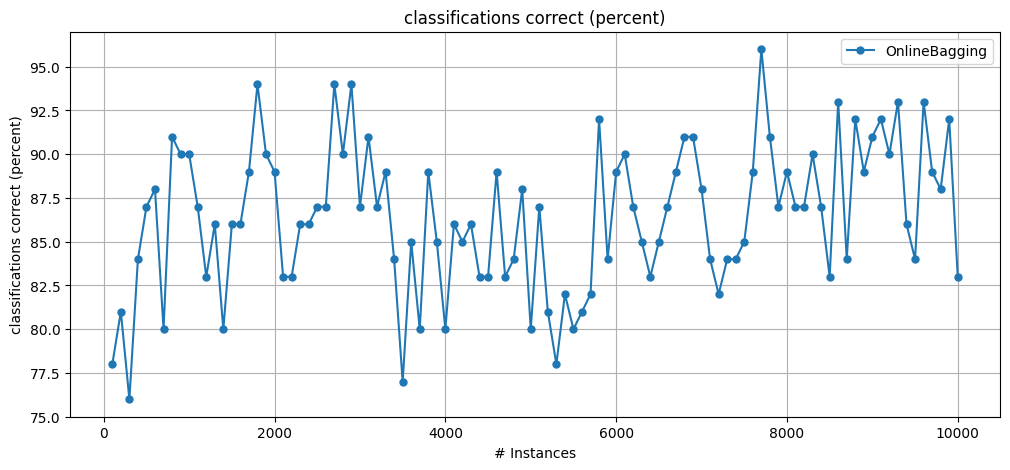

In [10]:
from capymoa.stream import Stream
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from moa.streams import ConceptDriftStream

# Using the API to generate the data using the ConceptDriftStream and AgrawalGenerator.
# The drift location is based on the number of instances (5000) as well as the drift width (1000, the default value) 
stream_sea1drift = Stream(moa_stream=ConceptDriftStream(), 
                          CLI="-s generators.SEAGenerator -d (generators.SEAGenerator -f 2) -p 5000 -w 1000")

OB = OnlineBagging(schema=stream_sea1drift.get_schema(), ensemble_size=10)

results_sea1drift_OB = prequential_evaluation(stream=stream_sea1drift, learner=OB, window_size=100, max_instances=10000)

plot_windowed_results(results_sea1drift_OB)

## 7. Drift, Multi-threated Ensemble and Results

* Generate a stream with 3 drifts, 2 abrupt and one gradual. 
* Evaluate utilising test-then-train (cumulative) and windowed evaluation.
* Execute a multi-threated version of AdaptiveRandomForest. 

None
Cumulative accuracy = 89.404
wallclock = 66.81768298149109 seconds


,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),Precision (percent),Precision for class 0 (percent),Precision for class 1 (percent),Recall (percent),Recall for class 0 (percent),Recall for class 1 (percent)
0,1000.0,85.2,66.356143,67.328918,57.593123,83.382272,77.230769,89.037037,84.684338,83.388704,85.979971,82.119640,71.919771,92.319508
1,2000.0,88.4,74.507848,75.578947,68.900804,87.483903,83.333333,91.104294,88.761656,89.783282,87.740030,86.242416,77.747989,94.736842
2,3000.0,88.8,74.666136,75.809935,67.630058,87.445835,82.978723,91.654247,88.444767,87.500000,89.389535,86.469216,78.901734,94.036697
3,4000.0,89.3,76.697185,77.038627,71.989529,88.629744,84.908322,91.711851,90.006634,92.048930,87.964339,87.294346,78.795812,95.792880
4,5000.0,89.5,75.802660,75.581395,68.562874,88.013413,83.464567,92.307692,89.084311,88.039867,90.128755,86.967956,79.341317,94.594595
5,6000.0,89.1,76.394868,77.755102,71.240106,88.321924,84.882108,91.477717,89.189730,89.473684,88.905775,87.470842,80.738786,94.202899
6,7000.0,89.1,76.064788,76.906780,70.855615,88.276122,84.361549,91.634689,89.602416,91.021672,88.183161,86.988519,78.609626,95.367412
7,8000.0,89.5,76.456343,77.754237,70.338983,88.377313,84.304933,92.111195,89.506430,89.523810,89.489051,87.276329,79.661017,94.891641
8,9000.0,88.7,75.023209,75.698925,69.459459,87.775266,83.551674,91.393755,89.192004,90.536278,87.847731,86.402831,77.567568,95.238095
9,10000.0,89.0,75.587238,76.545842,69.273743,87.890612,83.918129,91.641337,88.751343,88.036810,89.465875,87.046416,80.167598,93.925234


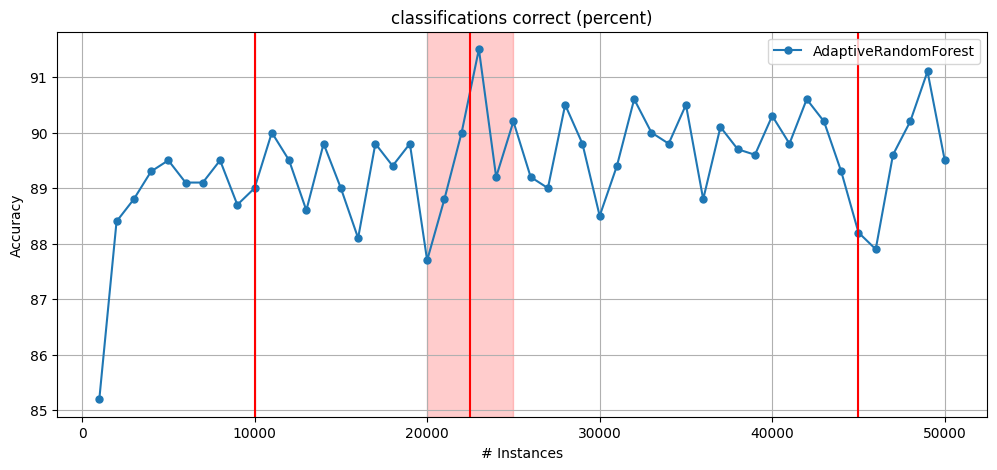

In [11]:
from capymoa.stream.generator import SEA
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

SEA3drifts = DriftStream(stream=[SEA(1), 
                                  AbruptDrift(10000),
                                  SEA(2), 
                                  GradualDrift(start=20000, end=25000), 
                                  SEA(3), 
                                  AbruptDrift(45000),
                                  SEA(1)])

arf = AdaptiveRandomForestClassifier(schema=SEA3drifts.get_schema(), 
                                     ensemble_size=100, 
                                     number_of_jobs=4)

results = prequential_evaluation(stream=SEA3drifts, 
                                 learner=arf, 
                                 window_size=1000, 
                                 max_instances=50000)

print(f"Cumulative accuracy = {results['cumulative'].accuracy()}")
print(f"wallclock = {results['wallclock']} seconds")
display(results['windowed'].metrics_per_window())
plot_windowed_results(results, ylabel='Accuracy')